In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import multinomial
from scipy.special import loggamma, xlogy
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS

In [124]:
def new_z(contigs):
    mean = contigs.mean(axis=0)
    fractions = mean/mean.sum()
    E = (contigs.sum(axis=1) * np.ones(contigs.shape).T).T * fractions
    alt_z = (contigs - E)/np.sqrt(E)
    return alt_z


def multi(x, p):
    n = np.sum(x)
    logp = loggamma(n+1) - np.sum(loggamma(x+1)) + np.sum(xlogy(x,p))
    return logp

def non_norm_multi(x, p):
    logp = np.sum(xlogy(x,p))
    return logp

def get_r(c, n, p, pi):
    L = np.zeros((n,len(c)))
    for k in range(n):
        for i in range(len(c)):
            L[k,i] = np.log(pi[k]) + non_norm_multi(c[i], p[k])
            
    L_kc = L-L.max(axis=0)
    e_kc = np.exp(L_kc)
    r = e_kc * np.sum(e_kc, axis=0)
    
    return r


def new_pi(r):
    return (np.sum(r,axis=1)/r.shape[1])
    
    
def new_p(c, r, p):
    for i in range(len(p)):
        p[i] = np.sum(c.T * r[i], axis=1)/(c.sum(axis=1)*r[i]).sum()
        
    return p

In [166]:
counts = pd.read_csv("./pca3_tnf.csv")
labels = counts['genome']
labels = labels.values
counts = counts.drop('genome',axis=1)
c = counts.values

## Multinomial mixture model

In [167]:
#number of components
n = 2

pi = np.array([1/n]*n)

p = np.random.rand(256,n)
s = p.sum(axis=0)
p = (p/s).T

In [168]:
for i in range(20):
    r = get_r(c, n, p, pi)
    pi = new_pi(r)
    print(pi)
    p = new_p(c, r, p)

[0.15017425 0.85852498]
[0.48563173 0.51824482]
[0.52875775 0.47314048]
[0.53636856 0.46365008]
[0.53737146 0.46270044]
[0.53746588 0.46277238]
[0.53746715 0.46277327]
[0.53746719 0.4627733 ]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]
[0.5374672 0.4627733]


In [169]:
labels = []
for i in r.T:
    labels.append(np.argmax(i))

## PCA visualization

In [170]:
X = new_z(c)
pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

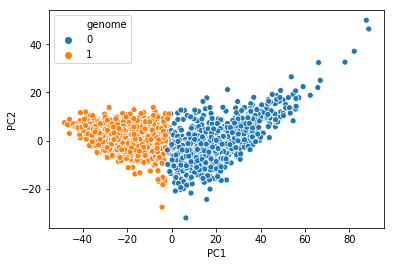

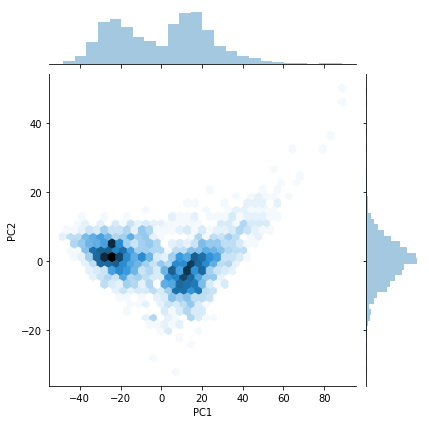

In [171]:
#PCA plot
pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])
pca_df['genome']=labels

sns.scatterplot(x='PC1', y='PC2', hue='genome', data=pca_df)
sns.jointplot(x='PC1', y='PC2', data=pca_df, kind="hex")


## Mixture model with clusters initialized by OPTICS